# Investigating eddy dynamics in relation to water mass structure

In [1]:
# Imports
import scipy.interpolate as interp
import numpy as np
from numpy import arange
import pandas as pd
import glob
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.animation import FuncAnimation
import gsw
import cmocean.cm as cmo
import sys
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader
from scipy.spatial import cKDTree
import matplotlib.gridspec as gridspec
from py_eddy_tracker.dataset.grid import RegularGridDataset, GridCollection
from py_eddy_tracker.observations.tracking import TrackEddiesObservations
from py_eddy_tracker.appli.gui import Anim
from geopy.distance import geodesic
from matplotlib.ticker import LogLocator
from matplotlib.colors import LogNorm
import copernicusmarine
from netCDF4 import Dataset
import copernicusmarine
import dbdreader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def calc_dist(lon1,lat1,lon2,lat2):
    return geodesic((lon1,lat1),(lon2,lat2))


/Users/joegradone/anaconda3/envs/RU29_69W/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load altimetry data

In [2]:
# ssh_ds = copernicusmarine.open_dataset(
#   dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D",
#   variables=["adt", "err_sla", "sla"],
#   minimum_longitude=-90,
#   maximum_longitude=-50,
#   minimum_latitude=5,
#   maximum_latitude=25,
#   start_datetime="2024-04-19T00:00:00",
#   end_datetime="2024-07-23T00:00:00",
# )

# ssh_ds['time'] = pd.to_datetime(ssh_ds.time.values)
# # This time format is really important for the tracking
# ssh_ds['time'] = ssh_ds.time.dt.strftime("%Y%m%d")
# ssh_ds['longitude'] = ssh_ds.longitude+360
# ssh_ds.to_netcdf('../data/CMEMS/cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D.nc')

## Save daily files for the eddy identification

In [3]:
# ssh_ds = xr.open_dataset('../data/CMEMS/cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D.nc')

# for x in np.arange(0,len(ssh_ds.time)):
#     subset = ssh_ds.isel(time=x)
#     fname = f'../data/CMEMS/daily/cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D_{subset.time.values}.nc'
#     subset.to_netcdf(fname)


## Load daily SSH fields, smooth, identify eddies, and save

In [4]:
# fnames = glob.glob('../data/CMEMS/daily/*.nc')


# for x in np.arange(0,len(fnames)):
#     ssh_ds = xr.open_dataset(fnames[x])
#     g = RegularGridDataset(fnames[x],"longitude","latitude","time",nan_masking=True)
#     date = pd.to_datetime(ssh_ds.time.values)

#     g.add_uv("adt", "ugos", "vgos")
#     g.add_uv("sla", "ugosa", "vgosa")
#     wavelength = 500
#     g.copy("adt", "adt_raw")
#     g.copy("sla", "sla_raw")
#     g.bessel_high_filter("adt", wavelength)
#     g.bessel_high_filter("sla", wavelength)
    
#     a_adt, c_adt = g.eddy_identification("adt", "ugos", "vgos", date, 0.002,force_speed_unit='m/s')
#     a_sla, c_sla = g.eddy_identification("sla", "ugosa", "vgosa", date, 0.002,force_speed_unit='m/s')
    
#     save_fname_adt_a = f'../data/CMEMS/eddy_identification_adt/AVISO_ADT_anticyclonic_{ssh_ds.time.values}.nc'
#     save_fname_adt_c = f'../data/CMEMS/eddy_identification_adt/AVISO_ADT_cyclonic_{ssh_ds.time.values}.nc'
    
#     save_fname_sla_a = f'../data/CMEMS/eddy_identification_sla/AVISO_SLA_anticyclonic_{ssh_ds.time.values}.nc'
#     save_fname_sla_c = f'../data/CMEMS/eddy_identification_sla/AVISO_SLA_cyclonic_{ssh_ds.time.values}.nc'
    
    
#     with Dataset(save_fname_adt_a, "w") as h:
#         a_adt.to_netcdf(h)
    
#     with Dataset(save_fname_adt_c, "w") as h:
#         c_adt.to_netcdf(h)
    
#     with Dataset(save_fname_sla_a, "w") as h:
#         a_sla.to_netcdf(h)
    
#     with Dataset(save_fname_sla_c, "w") as h:
#         c_sla.to_netcdf(h)
    


# Next make .yaml files with this format:

```yaml
PATHS:
  # Files produces with EddyIdentification
  FILES_PATTERN: ../data/CMEMS/eddy_identification_sla/*anticyclonic*.nc
  SAVE_DIR: ../data/CMEMS/eddy_track_sla_anticyclonic/

# Number of timestep for missing detection
VIRTUAL_LENGTH_MAX: 3
# Minimal time to consider as a full track
TRACK_DURATION_MIN: 10

CLASS:
    # Give the module to import,
    # must be available when you do "import module" in python
    MODULE: py_eddy_tracker.featured_tracking.area_tracker
    #MODULE: py_eddy_tracker.featured_tracking.old_tracker_reference
    # Give class name which must be inherit from
    # py_eddy_tracker.observations.observation.EddiesObservations
    #CLASS: CheltonTracker
    CLASS: AreaTracker
```

## And run in terminal with this command:

```console
EddyTracking tracking_anticyclones_sla.yaml -v
```

Need to have the python environment that py-eddy-tracker is installed in active but then run the command above in the directory where the .yaml file is.

## Now visualize the tracks

In [5]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_xlim(270, 310), ax.set_ylim(10, 22)
    ax.set_aspect("equal")
    ax.set_title(title)
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.95, 0.05, 0.01, 0.9]))

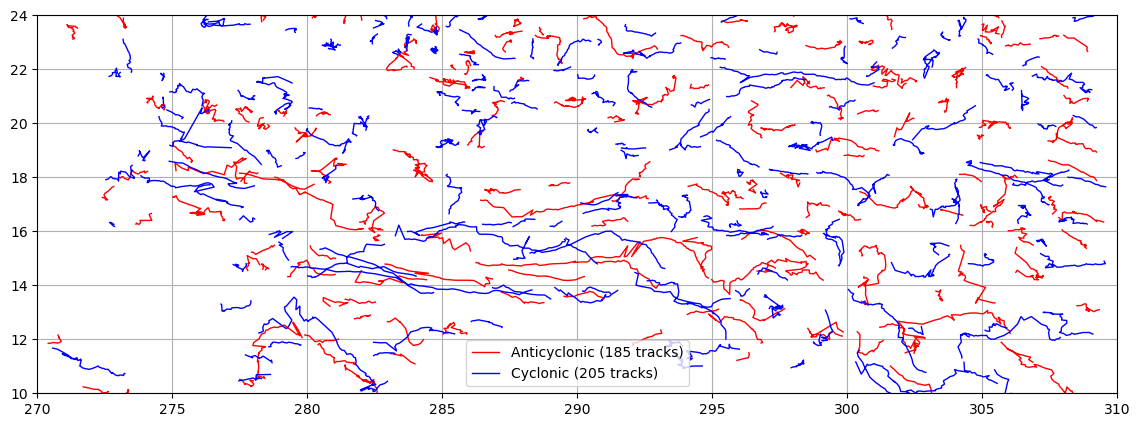

In [6]:
kwargs_load = dict(
    include_vars=(
        "longitude",
        "latitude",
        "observation_number",
        "track",
        "time",
        "speed_contour_longitude",
        "speed_contour_latitude",
    )
)
a = TrackEddiesObservations.load_file('../data/CMEMS/eddy_track_sla_anticyclonic/Anticyclonic.nc')
c = TrackEddiesObservations.load_file('../data/CMEMS/eddy_track_sla_cyclonic/Cyclonic.nc')


fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes((0.05, 0.1, 0.9, 0.9))
ax.set_aspect("equal")
ax.set_xlim(270, 310), ax.set_ylim(10, 24)
a.plot(ax, ref=-10, label="Anticyclonic ({nb_tracks} tracks)", color="r", lw=1)
c.plot(ax, ref=-10, label="Cyclonic ({nb_tracks} tracks)", color="b", lw=1)
ax.legend()
ax.grid()

In [7]:
atracks = np.unique(a.track)

eddy = a.extract_ids([atracks[0]])
eddy.longitude

array([301.32269287, 301.29156494, 301.24530029, 301.2276001 ,
       301.18286133, 301.16799927, 301.10083008, 301.04067993,
       300.95840454, 300.92773438, 300.78878784, 300.71551514,
       300.63278198, 300.55993652, 300.38381958, 300.4526062 ,
       300.45742798, 300.46224976, 300.36355591])

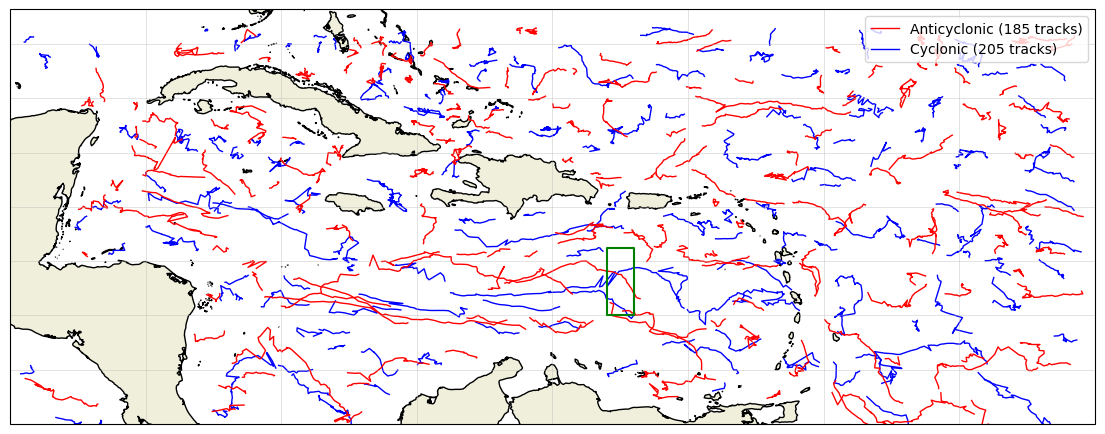

In [8]:
# count cyclone and antic
nc=c.track.size
na=a.track.size

ctracks = np.unique(c.track)
atracks = np.unique(a.track)


# Map extent
lon1 = -90
lon2 = -50
lat1 = 10
lat2 = 24


fig = plt.figure(figsize=(14,14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=cfeature.COLORS['land']
)
ax.add_feature(LAND, zorder=0)



for ind in atracks:
    eddy = a.extract_ids([ind])
    ax.plot(eddy.longitude-360,eddy.latitude,c='b',lw=1)
for ind in ctracks:
    eddy = c.extract_ids([ind])
    ax.plot(eddy.longitude-360,eddy.latitude,c='r',lw=1)


glb = ax.gridlines(draw_labels=False, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}

a.plot(ax, ref=-10, label="Anticyclonic ({nb_tracks} tracks)", color="r", lw=1)
c.plot(ax, ref=-10, label="Cyclonic ({nb_tracks} tracks)", color="b", lw=1)
ax.legend(loc='upper right')


x0, x1, y0, y1 =  3-70, -68, 14, 16.5
ax.plot(
    (x0, x0, x1, x1, x0),
    (y0, y1, y1, y0, y0),
    color="green",
    lw=1.5,
)

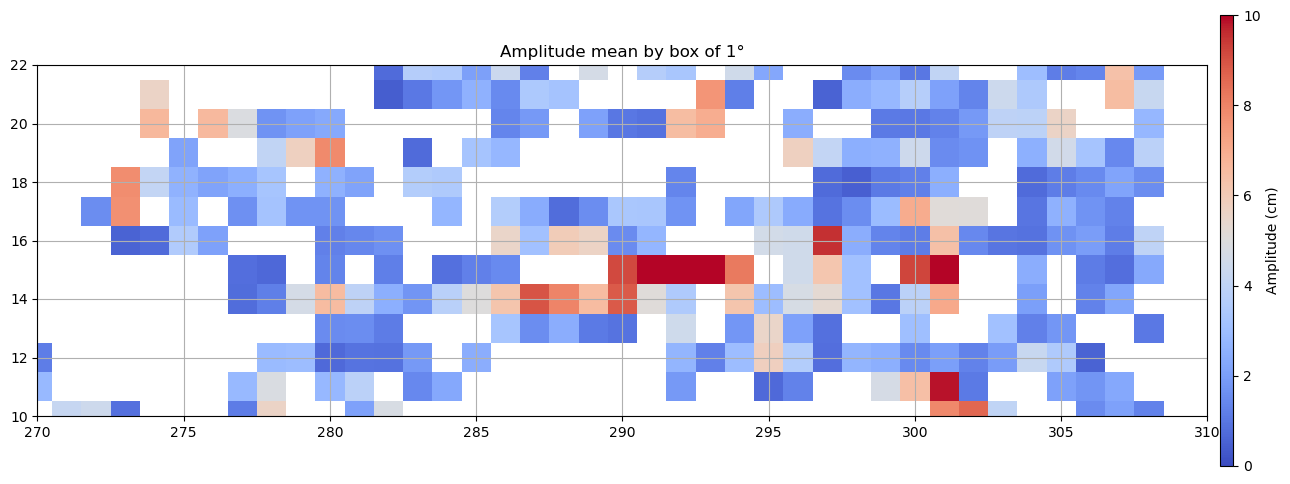

In [9]:
step=1
ax = start_axes("Amplitude mean by box of %s°" % step)
g = a.grid_stat(((270, 310, step), (10, 24, step)), "amplitude")
m = g.display(ax, name="amplitude", vmin=0, vmax=10, factor=100)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))
cb.set_label("Amplitude (cm)")

## First the cyclonic eddy we miss

In [10]:
c = TrackEddiesObservations.load_file('../data/CMEMS/eddy_track_sla_cyclonic/Cyclonic.nc')


t0 = (datetime(2024, 4, 1) - datetime(1950, 1, 1)).days
t1 = (datetime(2024, 6, 1) - datetime(1950, 1, 1)).days

## lon1, lon2, lat1, lat2
x0, x1, y0, y1 =  360-70, 360-68, 14, 16.75

c_subset = c.extract_with_mask((c.time >= t0) * (c.time < t1)).extract_with_area(
    dict(llcrnrlon=x0, urcrnrlon=x1, llcrnrlat=y0, urcrnrlat=y1)
)


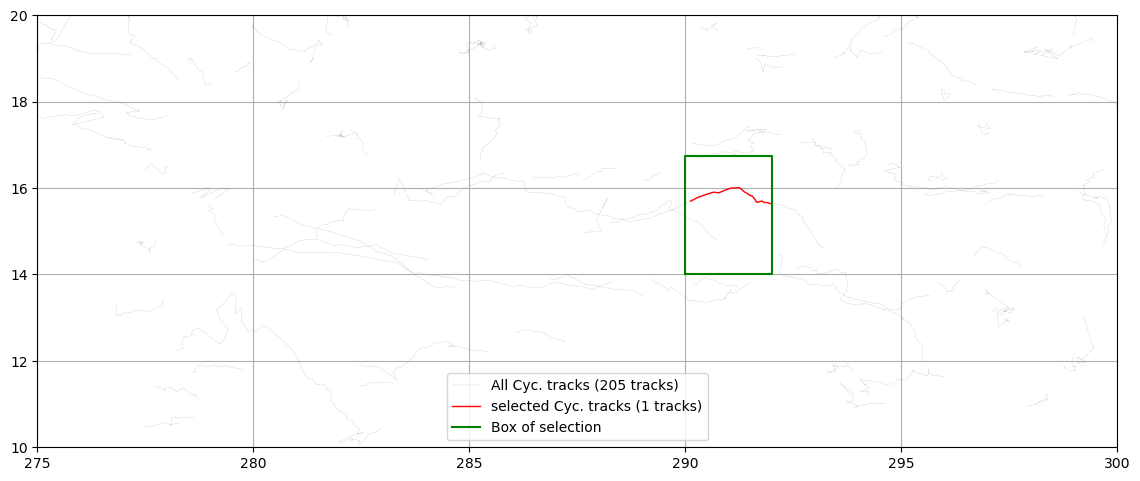

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9))
ax.set_xlim(275, 300)
ax.set_ylim(10, 20)
ax.set_aspect("equal")
ax.grid()

c.plot(ax, color="gray", lw=0.1, ref=-10, label="All Cyc. tracks ({nb_tracks} tracks)")
c_subset.plot(
    ax, color="red", lw=1, ref=-10, label="selected Cyc. tracks ({nb_tracks} tracks)"
)



ax.plot(
    (x0, x0, x1, x1, x0),
    (y0, y1, y1, y0, y0),
    color="green",
    lw=1.5,
    label="Box of selection",
)
ax.legend()

In [12]:
eddy_ID = c_subset.track[0]
eddy_ID

17

In [13]:
c = TrackEddiesObservations.load_file('../data/CMEMS/eddy_track_sla_cyclonic/Cyclonic.nc')
eddy = c.extract_ids([eddy_ID])
eddy

/Users/joegradone/anaconda3/envs/RU29_69W/lib/python3.11/site-packages/pyEddyTracker-0+untagged.753.g8fe5bf1-py3.11.egg/py_eddy_tracker/observations/observation.py:305: RuntimeWarning: invalid value encountered in divide
  v /= hist_numba(x, bins=bins)[0]


| 96 observations from 27137.0 to 27232.0 (96.0 days, ~1 obs/day)
    |   Speed area      : 0.02 Mkm²/day
    |   Effective area  : 0.03 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      2.08      6.25      9.38     12.50     51.04     18.75
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.00      2.08      9.38     21.88     50.00     16.67      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.00      1.04      6.25      9.38     47.92     35.42      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00      0.00      6.25     93.75      0.00
        Percent of speed area     :       0.00      0.00      6.14     93.86      0.00
        Percent of effective area :       0.00      0.00     16.14     83.86      0.00
        Mean speed radius (km)    :        nan       nan     81.06     81.51       nan
        Mean effective radius (km):        nan       nan    164.98     92.36       nan
        Mean amplitude (cm)       :        nan       nan     18.38      6.30       nan
    | 1 tracks (96.00 obs/tracks, shorter 96 obs, longer 96 obs)
    |   1 filled observations (1.00 obs/tracks, 1.04 % of total)
    |   Intepolated speed area      : 0.00 Mkm²/day
    |   Intepolated effective area  : 0.00 Mkm²/day
    |   Distance by day             : Mean 12.50 , Median 11.70 km/day
    |   Distance by track           : Mean 1174.84 , Median 1174.84 km/track
    ----Distribution in lifetime:
    |   Lifetime (days  )            1.00     30.00     90.00    180.00    270.00    365.00   1000.00  10000.00
    |   Percent of tracks         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00
    |   Percent of eddies         :       0.00      0.00    100.00      0.00      0.00      0.00      0.00

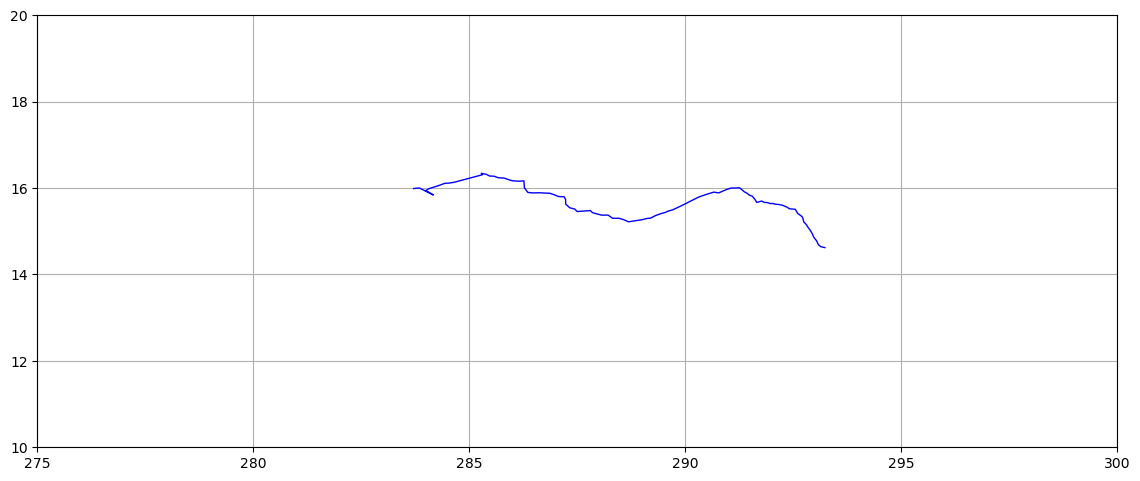

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9))
ax.set_xlim(275, 300)
ax.set_ylim(10, 20)
ax.set_aspect("equal")
ax.grid()

eddy.plot(ax, color="blue", lw=1, ref=-10)



In [15]:
eddy_lon = eddy.lon-360
eddy_lat = eddy.lat
eddy_time = pd.to_datetime(eddy.time,origin='1950-01-01',unit='D')
eddy_amplitude = eddy.amplitude
eddy_effective_contour_height = eddy.effective_contour_height
eddy_effective_area = eddy.effective_area
eddy_effective_radius = eddy.effective_radius
eddy_speed_average = eddy.speed_average


d = {'time':eddy_time,'lon':eddy_lon, 'lat':eddy_lat,'amplitude':eddy_amplitude,'effective_contour_height':eddy_effective_contour_height,
    'effective_area': eddy_effective_area,'effective_radius':eddy_effective_radius,'speed_average':eddy_speed_average}

eddy_df = pd.DataFrame(d)
eddy_df

,time,lon,lat,amplitude,effective_contour_height,effective_area,effective_radius,speed_average
0,2024-04-19,-66.771057,14.621905,0.1942,-0.016,6.083956e+10,155700.0,0.6345
1,2024-04-20,-66.864166,14.642264,0.2014,-0.008,7.621888e+10,171750.0,0.6114
2,2024-04-21,-66.921783,14.686530,0.1879,-0.006,7.765894e+10,169150.0,0.5647
3,2024-04-22,-66.964996,14.779646,0.1759,-0.006,7.640151e+10,164100.0,0.5334
4,2024-04-23,-67.027100,14.856772,0.1783,-0.004,7.862544e+10,172800.0,0.5480
...,...,...,...,...,...,...,...,...
91,2024-07-19,-75.942169,15.985636,0.0459,-0.086,1.551784e+10,77600.0,0.3181
92,2024-07-20,-76.008911,15.942765,0.0577,-0.080,2.334445e+10,99000.0,0.3200
93,2024-07-21,-75.837982,15.840734,0.0692,-0.070,2.923262e+10,106750.0,0.3665
94,2024-07-22,-76.159973,16.002533,0.0228,-0.114,7.514246e+09,54400.0,0.2831


In [16]:
eddy_df.speed_average.max()

0.6345000267028809

## Ok now zoom in on a window to identify the eddy we want

In [17]:
a = TrackEddiesObservations.load_file('../data/CMEMS/eddy_track_sla_anticyclonic/Anticyclonic.nc')
c = TrackEddiesObservations.load_file('../data/CMEMS/eddy_track_sla_cyclonic/Cyclonic.nc')


t0 = (datetime(2024, 6, 1) - datetime(1950, 1, 1)).days
t1 = (datetime(2024, 7, 1) - datetime(1950, 1, 1)).days

## lon1, lon2, lat1, lat2
x0, x1, y0, y1 =  360-70, 360-68, 14, 16.5

c_subset = c.extract_with_mask((c.time >= t0) * (c.time < t1)).extract_with_area(
    dict(llcrnrlon=x0, urcrnrlon=x1, llcrnrlat=y0, urcrnrlat=y1)
)

a_subset = a.extract_with_mask((a.time >= t0) * (a.time < t1)).extract_with_area(
    dict(llcrnrlon=x0, urcrnrlon=x1, llcrnrlat=y0, urcrnrlat=y1)
)

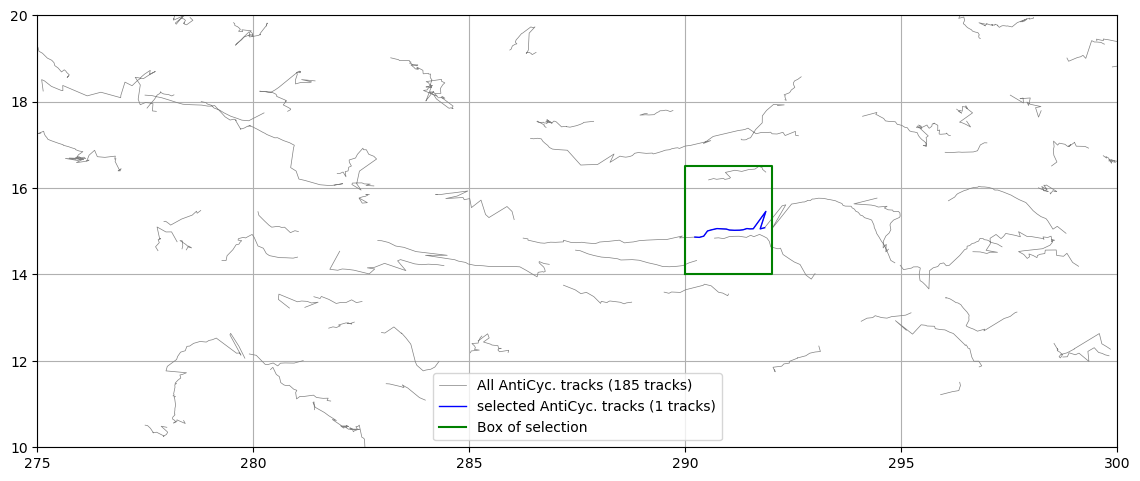

In [18]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9))
ax.set_xlim(275, 300)
ax.set_ylim(10, 20)
ax.set_aspect("equal")
ax.grid()
# c.plot(ax, color="gray", lw=0.1, ref=-10, label="All Cyc. tracks ({nb_tracks} tracks)")
# c_subset.plot(
#     ax, color="red", lw=1, ref=-10, label="selected Cyc. tracks ({nb_tracks} tracks)"
# )

a.plot(ax, color="gray", lw=0.5, ref=-10, label="All AntiCyc. tracks ({nb_tracks} tracks)")
a_subset.plot(
    ax, color="blue", lw=1, ref=-10, label="selected AntiCyc. tracks ({nb_tracks} tracks)"
)



# c.plot(ax, color="gray", lw=0.5, ref=-10, label="All Cyc. tracks ({nb_tracks} tracks)")
# c_subset.plot(
#     ax, color="red", lw=1, ref=-10, label="selected Cyc. tracks ({nb_tracks} tracks)"
# )


ax.plot(
    (x0, x0, x1, x1, x0),
    (y0, y1, y1, y0, y0),
    color="green",
    lw=1.5,
    label="Box of selection",
)
ax.legend()

In [19]:
eddy_ID = a_subset.track[0]
eddy_ID

27

In [20]:
a = TrackEddiesObservations.load_file('../data/CMEMS/eddy_track_sla_anticyclonic/Anticyclonic.nc')
eddy = a.extract_ids([eddy_ID])

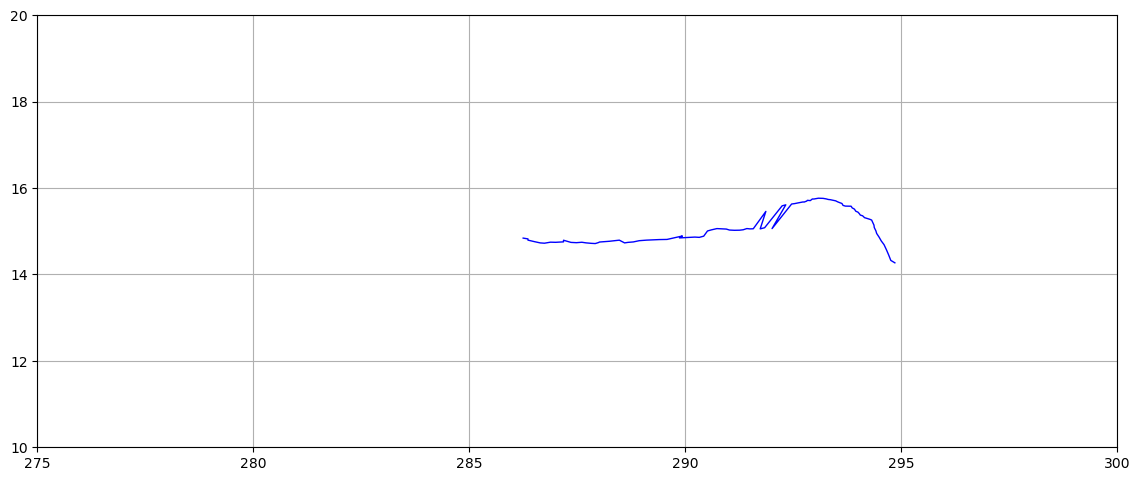

In [21]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes((0.05, 0.05, 0.9, 0.9))
ax.set_xlim(275, 300)
ax.set_ylim(10, 20)
ax.set_aspect("equal")
ax.grid()

eddy.plot(ax, color="blue", lw=1, ref=-10)



In [22]:
eddy.field_table

/Users/joegradone/anaconda3/envs/RU29_69W/lib/python3.11/site-packages/pyEddyTracker-0+untagged.753.g8fe5bf1-py3.11.egg/py_eddy_tracker/observations/observation.py:305: RuntimeWarning: invalid value encountered in divide
  v /= hist_numba(x, bins=bins)[0]


<bound method EddiesObservations.field_table of     | 96 observations from 27137.0 to 27232.0 (96.0 days, ~1 obs/day)
    |   Speed area      : 0.06 Mkm²/day
    |   Effective area  : 0.08 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.00      0.00      0.00      0.00      0.00     21.88     78.12
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.00      0.00      0.00      0.00     32.29     54.17     13.54
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      0.00      0.00      0.00      0.00      0.00     76.04     23.96
    ----Distribution in Latitude
     

## Resave vars for comparison with glider data

In [23]:
eddy_lon = eddy.lon-360
eddy_lat = eddy.lat
eddy_time = pd.to_datetime(eddy.time,origin='1950-01-01',unit='D')
eddy_amplitude = eddy.amplitude
eddy_effective_contour_height = eddy.effective_contour_height
eddy_effective_area = eddy.effective_area
eddy_effective_radius = eddy.effective_radius

d = {'time':eddy_time,'lon':eddy_lon, 'lat':eddy_lat,'amplitude':eddy_amplitude,'effective_contour_height':eddy_effective_contour_height,
    'effective_area': eddy_effective_area,'effective_radius':eddy_effective_radius}

eddy_df = pd.DataFrame(d)
eddy_df

,time,lon,lat,amplitude,effective_contour_height,effective_area,effective_radius
0,2024-04-19,-65.152863,14.269757,0.0889,0.050,3.275209e+10,116050.0
1,2024-04-20,-65.246918,14.325865,0.0875,0.046,3.555183e+10,121950.0
2,2024-04-21,-65.295105,14.448403,0.0782,0.056,2.993164e+10,111150.0
3,2024-04-22,-65.345825,14.566694,0.0881,0.052,3.093456e+10,113600.0
4,2024-04-23,-65.403564,14.690346,0.0859,0.054,2.890314e+10,109100.0
...,...,...,...,...,...,...,...
91,2024-07-19,-73.362335,14.730769,0.1150,0.012,1.123507e+11,198400.0
92,2024-07-20,-73.500885,14.761019,0.1154,0.012,1.141290e+11,202250.0
93,2024-07-21,-73.645721,14.795103,0.1216,0.012,1.116126e+11,200000.0
94,2024-07-22,-73.646088,14.823568,0.1268,0.008,1.198240e+11,216150.0


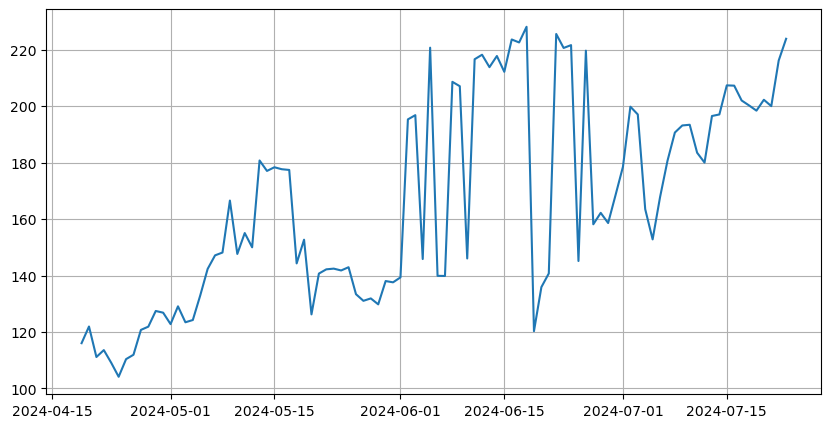

In [24]:
plt.figure(figsize=(10,5))
plt.plot(eddy_df.time,eddy_df.effective_radius/1000)
plt.grid()

## Load AD2CP data

In [25]:
adcp_ds = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP.nc')
adcp_ds

<xarray.Dataset> Size: 813kB
Dimensions:     (depth: 100, time: 486)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2024-04-19T14:50:04 ... 2024-06-30T...
  * depth       (depth) float64 800B 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
Data variables:
    u_grid      (depth, time) float64 389kB ...
    v_grid      (depth, time) float64 389kB ...
    latitude    (time) float64 4kB ...
    longitude   (time) float64 4kB ...
    start_lat   (time) float64 4kB ...
    start_lon   (time) float64 4kB ...
    end_lat     (time) float64 4kB ...
    end_lon     (time) float64 4kB ...
    start_time  (time) datetime64[ns] 4kB ...
    end_time    (time) datetime64[ns] 4kB ...
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

## Load glider data

In [26]:
gridded_glider = xr.open_dataset('../data/processed_nc/RU29_2024_depth_gridded_glider_erddap_oxygen.nc')

gridded_glider

<xarray.Dataset> Size: 87MB
Dimensions:                                  (depth: 499, time: 1362)
Coordinates:
  * depth                                    (depth) float64 4kB 1.0 ... 997.0
  * time                                     (time) datetime64[ns] 11kB 2024-...
    latitude                                 (time) float64 11kB ...
    longitude                                (time) float64 11kB ...
Data variables: (12/16)
    temperature                              (depth, time) float64 5MB ...
    temperature_counts                       (depth, time) int64 5MB ...
    practical_salinity                       (depth, time) float64 5MB ...
    practical_salinity_counts                (depth, time) int64 5MB ...
    oxygen_concentration_shifted_mgL         (depth, time) float64 5MB ...
    oxygen_concentration_shifted_mgL_counts  (depth, time) int64 5MB ...
    ...                                       ...
    conservative_temperature                 (depth, time) float64 5MB ...
    conservative_temperature_counts          (depth, time) int64 5MB ...
    rho                                      (depth, time) float64 5MB ...
    rho_counts                               (depth, time) int64 5MB ...
    sigma                                    (depth, time) float64 5MB ...
    sigma_counts                             (depth, time) int64 5MB ...

In [27]:
def calc_dist(lon1,lat1,lon2,lat2):
    return geodesic((lon1,lat1),(lon2,lat2))

match_time = np.empty(len(gridded_glider.time))
match_time[:] = np.nan
match_distance = np.empty(len(gridded_glider.time))
match_distance[:] = np.nan
match_diameter = np.empty(len(gridded_glider.time))
match_diameter[:] = np.nan
match_potential_temperature = np.empty(gridded_glider.potential_temperature.shape)
match_potential_temperature[:] = np.nan
match_conservative_temperature = np.empty(gridded_glider.potential_temperature.shape)
match_conservative_temperature[:] = np.nan
match_absolute_salinity = np.empty(gridded_glider.absolute_salinity.shape)
match_absolute_salinity[:] = np.nan
match_oxygen = np.empty(gridded_glider.absolute_salinity.shape)
match_oxygen[:] = np.nan



for x in np.arange(0,len(gridded_glider.time)):
    time_diff = gridded_glider.time.values[x]-eddy_df.time
    time_ind = np.argmin(np.abs(time_diff))
    match_distancet = geodesic((gridded_glider.longitude[x],gridded_glider.latitude[x]),(eddy_df.lon[time_ind],eddy_df.lat[time_ind])).km
    match_diametert = (eddy_df.effective_radius[time_ind]*2)/1000

    ## Only call it a match if the distance between the glider and the eddy is less than the diameter of the eddy
    if match_distancet < match_diametert:
        match_distance[x] = match_distancet
        match_diameter[x] = match_diametert
        match_time[x] = eddy_df.time[time_ind].timestamp()

        match_conservative_temperature[:,x] = gridded_glider.conservative_temperature.isel(time=x)
        match_potential_temperature[:,x] = gridded_glider.potential_temperature.isel(time=x)
        match_absolute_salinity[:,x] = gridded_glider.absolute_salinity.isel(time=x)        
        match_oxygen[:,x] = gridded_glider.oxygen_concentration_shifted_mgL.isel(time=x)

    else:
        continue


match_time = pd.to_datetime(match_time,unit='s')

## drop nan now for cleaner plotting later on

In [28]:
match_inds = np.where(np.isnan(match_distance)==False)[0]

match_distance = match_distance[match_inds]
match_diameter = match_diameter[match_inds]
match_time = match_time[match_inds]


match_conservative_temperature = match_conservative_temperature[:,match_inds]
match_potential_temperature = match_potential_temperature[:,match_inds]
match_absolute_salinity = match_absolute_salinity[:,match_inds]
match_oxygen = match_oxygen[:,match_inds]


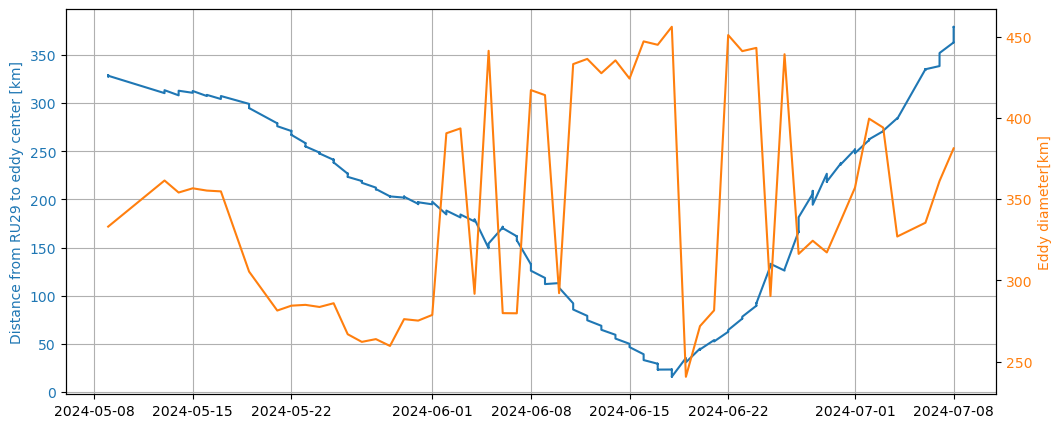

In [29]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Plot on primary y-axis
ax1.plot(match_time,match_distance,color='tab:blue')
ax1.set_ylabel("Distance from RU29 to eddy center [km]", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(match_time,match_diameter,color='tab:orange')
ax2.set_ylabel("Eddy diameter[km]", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

ax1.grid()

## Calculate 50 km range from the edge of the eddy for mean temperature and salinity profiles

In [30]:
## Exclude profiles where time is too close to Beryl
subset_gridded_glider = gridded_glider.sel(time=slice(None, "2024-07-01"))


edge_time = np.empty(len(subset_gridded_glider.time))
edge_time[:] = np.nan
edge_distance = np.empty(len(subset_gridded_glider.time))
edge_distance[:] = np.nan
edge_diameter = np.empty(len(subset_gridded_glider.time))
edge_diameter[:] = np.nan
edge_potential_temperature = np.empty(subset_gridded_glider.potential_temperature.shape)
edge_potential_temperature[:] = np.nan
edge_conservative_temperature = np.empty(subset_gridded_glider.conservative_temperature.shape)
edge_conservative_temperature[:] = np.nan
edge_absolute_salinity = np.empty(subset_gridded_glider.absolute_salinity.shape)
edge_absolute_salinity[:] = np.nan
edge_oxygen = np.empty(subset_gridded_glider.absolute_salinity.shape)
edge_oxygen[:] = np.nan

for x in np.arange(0,len(subset_gridded_glider.time)):
    time_diff = subset_gridded_glider.time.values[x]-eddy_df.time
    time_ind = np.argmin(np.abs(time_diff))
    edge_distancet = geodesic((subset_gridded_glider.longitude[x],subset_gridded_glider.latitude[x]),(eddy_df.lon[time_ind],eddy_df.lat[time_ind])).km
    edge_diametert = (eddy_df.effective_radius[time_ind]*2)/1000

    ## Only call it a match if the distance between the glider and the eddy is greater than the diameter of the eddy but less than the diameter of eddy + 50 km
    if (edge_distancet < edge_diametert+50) & (edge_distancet>edge_diametert):
        edge_distance[x] = edge_distancet
        edge_diameter[x] = edge_diametert
        edge_time[x] = eddy_df.time[time_ind].timestamp()

        edge_conservative_temperature[:,x] = subset_gridded_glider.conservative_temperature.isel(time=x)
        edge_potential_temperature[:,x] = subset_gridded_glider.potential_temperature.isel(time=x)
        edge_absolute_salinity[:,x] = subset_gridded_glider.absolute_salinity.isel(time=x)
        edge_oxygen[:,x] = gridded_glider.oxygen_concentration_shifted_mgL.isel(time=x)
    else:
        continue


edge_time = pd.to_datetime(edge_time,unit='s')

## Drop nan for cleaner plotting

In [31]:
edge_inds = np.where(np.isnan(edge_distance)==False)[0]

edge_distance = edge_distance[edge_inds]
edge_diameter = edge_diameter[edge_inds]
edge_time = edge_time[edge_inds]

edge_conservative_temperature = edge_conservative_temperature[:,edge_inds]
edge_potential_temperature = edge_potential_temperature[:,edge_inds]
edge_absolute_salinity = edge_absolute_salinity[:,edge_inds]
edge_oxygen = edge_oxygen[:,edge_inds]


In [32]:
mean_conservative_temperature_profile = np.nanmean(edge_conservative_temperature,axis=1)
mean_potential_temperature_profile = np.nanmean(edge_potential_temperature,axis=1)
mean_absolute_salinity_profile = np.nanmean(edge_absolute_salinity,axis=1)
mean_oxygen_profile = np.nanmean(edge_oxygen,axis=1)


eddy_conservative_temperature_anomaly = np.where(np.isnan(match_conservative_temperature), np.nan, match_conservative_temperature - mean_conservative_temperature_profile[:, np.newaxis])
eddy_potential_temperature_anomaly = np.where(np.isnan(match_potential_temperature), np.nan, match_potential_temperature - mean_potential_temperature_profile[:, np.newaxis])
eddy_absolute_salinity_anomaly = np.where(np.isnan(match_absolute_salinity), np.nan, match_absolute_salinity - mean_absolute_salinity_profile[:, np.newaxis])
eddy_oxygen_anomaly = np.where(np.isnan(match_oxygen), np.nan, match_oxygen - mean_oxygen_profile[:, np.newaxis])


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46270/2272613292.py:1: RuntimeWarning: Mean of empty slice
  mean_conservative_temperature_profile = np.nanmean(edge_conservative_temperature,axis=1)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46270/2272613292.py:2: RuntimeWarning: Mean of empty slice
  mean_potential_temperature_profile = np.nanmean(edge_potential_temperature,axis=1)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46270/2272613292.py:3: RuntimeWarning: Mean of empty slice
  mean_absolute_salinity_profile = np.nanmean(edge_absolute_salinity,axis=1)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46270/2272613292.py:4: RuntimeWarning: Mean of empty slice
  mean_oxygen_profile = np.nanmean(edge_oxygen,axis=1)


## Now add actual altimetry from over glider to these plots

In [33]:
def match_ssh_to_glider(gridded_glider: xr.Dataset, ssh_ds: xr.Dataset) -> pd.DataFrame:
    """
    Matches the nearest SSH dataset (sla and adt) values in space and time to each time, latitude, and longitude point 
    in the glider dataset.
    
    Parameters:
    gridded_glider (xr.Dataset): Xarray dataset with latitude, longitude, and time.
    ssh_ds (xr.Dataset): Xarray dataset with latitude, longitude, time, and variables 'sla' and 'adt'.

    Returns:
    pd.DataFrame: A pandas DataFrame containing matched sla, adt, time, latitude, and longitude.
    """
    # Convert times to datetime64[ns]
    gridded_glider = gridded_glider.assign_coords(time=pd.to_datetime(gridded_glider.time))
    
    # Convert ssh_ds.time to datetime and set as index
    ssh_ds = ssh_ds.assign_coords(time=pd.to_datetime(ssh_ds.time))
    
    # Ensure ssh_ds.time is a proper pandas Index to avoid float issues
    ssh_ds["time"] = ("time", pd.DatetimeIndex(ssh_ds.time.values))

    # Sort by time to prevent selection issues
    ssh_ds = ssh_ds.sortby("time")

    # Handle missing times: Use nearest time and spatial index
    matched_sla = []
    matched_adt = []
    matched_times = []
    matched_lat = []
    matched_lon = []
    
    for t in np.arange(0,len(gridded_glider.time)):
        # Find the closest SSH time for this specific time
        time_diff = np.abs(ssh_ds.time.values - gridded_glider.time.values[t])
        closest_time_idx = np.argmin(time_diff)
        
        # For each latitude and longitude pair, find the closest spatial coordinates in SSH dataset
        # Find the closest latitude and longitude in SSH data (nearest-neighbor)
        lat_diff = np.abs(ssh_ds.latitude.values - gridded_glider.latitude.values[t])
        lon_diff = np.abs(ssh_ds.longitude.values - gridded_glider.longitude.values[t])
        closest_lat_idx = np.argmin(lat_diff)
        closest_lon_idx = np.argmin(lon_diff)
        
        # Append the matched values for sla and adt
        matched_sla.append(ssh_ds.sla.values[closest_time_idx, closest_lat_idx, closest_lon_idx])
        matched_adt.append(ssh_ds.adt.values[closest_time_idx, closest_lat_idx, closest_lon_idx])

        # Append the corresponding time, latitude, and longitude from the gridded glider dataset
        matched_times.append(gridded_glider.time.values[t])
        matched_lat.append(gridded_glider.latitude.values[t])
        matched_lon.append(gridded_glider.longitude.values[t])

    # Create a pandas DataFrame
    matched_df = pd.DataFrame({
        "matched_time": matched_times,
        "matched_lat": matched_lat,
        "matched_lon": matched_lon,
        "matched_sla": matched_sla,
        "matched_adt": matched_adt
    })

    return matched_df


In [34]:
ssh_ds = copernicusmarine.open_dataset(
  dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D",
  variables=["adt", "err_sla", "sla"],
  minimum_longitude=-90,
  maximum_longitude=-50,
  minimum_latitude=5,
  maximum_latitude=25,
  start_datetime="2024-04-19T00:00:00",
  end_datetime="2024-07-23T00:00:00",
)

glider_sla = match_ssh_to_glider(gridded_glider, ssh_ds)

glider_sla


INFO - 2025-09-18T13:04:48Z - Selected dataset version: "202311"
INFO - 2025-09-18T13:04:48Z - Selected dataset part: "default"


,matched_time,matched_lat,matched_lon,matched_sla,matched_adt
0,2024-04-19 14:32:05,17.779417,-67.057943,0.0059,0.6493
1,2024-04-19 14:48:10,17.780110,-67.059912,0.0059,0.6493
2,2024-04-19 15:16:07,17.780477,-67.061363,0.0059,0.6493
3,2024-04-19 16:18:01,17.776382,-67.070877,0.0059,0.6493
4,2024-04-19 16:33:48,17.776509,-67.071073,0.0059,0.6493
...,...,...,...,...,...
1357,2024-07-23 09:40:22,17.850184,-67.035087,0.0805,0.7239
1358,2024-07-23 09:49:05,17.850152,-67.036773,0.0805,0.7239
1359,2024-07-23 10:35:53,17.849934,-67.035646,0.0805,0.7239
1360,2024-07-23 10:35:53,17.849934,-67.035646,0.0805,0.7239


## Load glider heading for plotting orientation

In [35]:
data_files = "../data/logs/*.[DE]BD"
cac_dir = "../data/cache/"

## Initialize dbd class
dbd = dbdreader.MultiDBD(pattern = data_files,
                         cacheDir=cac_dir)

## Since time stamp of flight and science parameters on CTD time stamp
tctd, heading, lat, lon = dbd.get_sync("m_heading","m_lat","m_lon")
## Reformat time
tctd = pd.to_datetime(tctd, unit='s')

## Stuff data in a pandas dataframe
d = {'time': tctd, 'heading':heading, 'latitude':lat, 'longitude':lon}
gdf = pd.DataFrame(d)

## Correct for mag_var
gdf['heading'] = gdf.heading-0.22
## Convert to degrees
gdf['heading'] = np.rad2deg(gdf.heading)


gdf.set_index('time', inplace=True)

# Compute a rolling mean of the heading for cleaner plotting
gdf['rolling_mean_heading'] = gdf['heading'].rolling('1D').mean()

gdf = gdf.reset_index()
gdf

,time,heading,latitude,longitude,rolling_mean_heading
0,2024-04-19 14:16:52.980926514,9.694929,17.779113,-67.056552,9.694929
1,2024-04-19 14:23:30.711273193,9.694929,17.779347,-67.057548,9.694929
2,2024-04-19 14:25:20.462890625,81.094926,17.779270,-67.057884,33.494928
3,2024-04-19 14:25:35.782440186,74.294927,17.779284,-67.057830,43.694928
4,2024-04-19 14:25:50.821563721,74.194926,17.779284,-67.057830,49.794928
...,...,...,...,...,...
1685430,2024-07-23 11:25:04.962066650,108.294932,17.850084,-67.036719,65.424662
1685431,2024-07-23 11:25:09.722442627,100.794927,17.850084,-67.036723,65.427478
1685432,2024-07-23 11:25:14.668395996,94.594925,17.850085,-67.036727,65.431275
1685433,2024-07-23 11:25:19.439575195,86.394928,17.850085,-67.036730,65.433865


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46270/1515810496.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


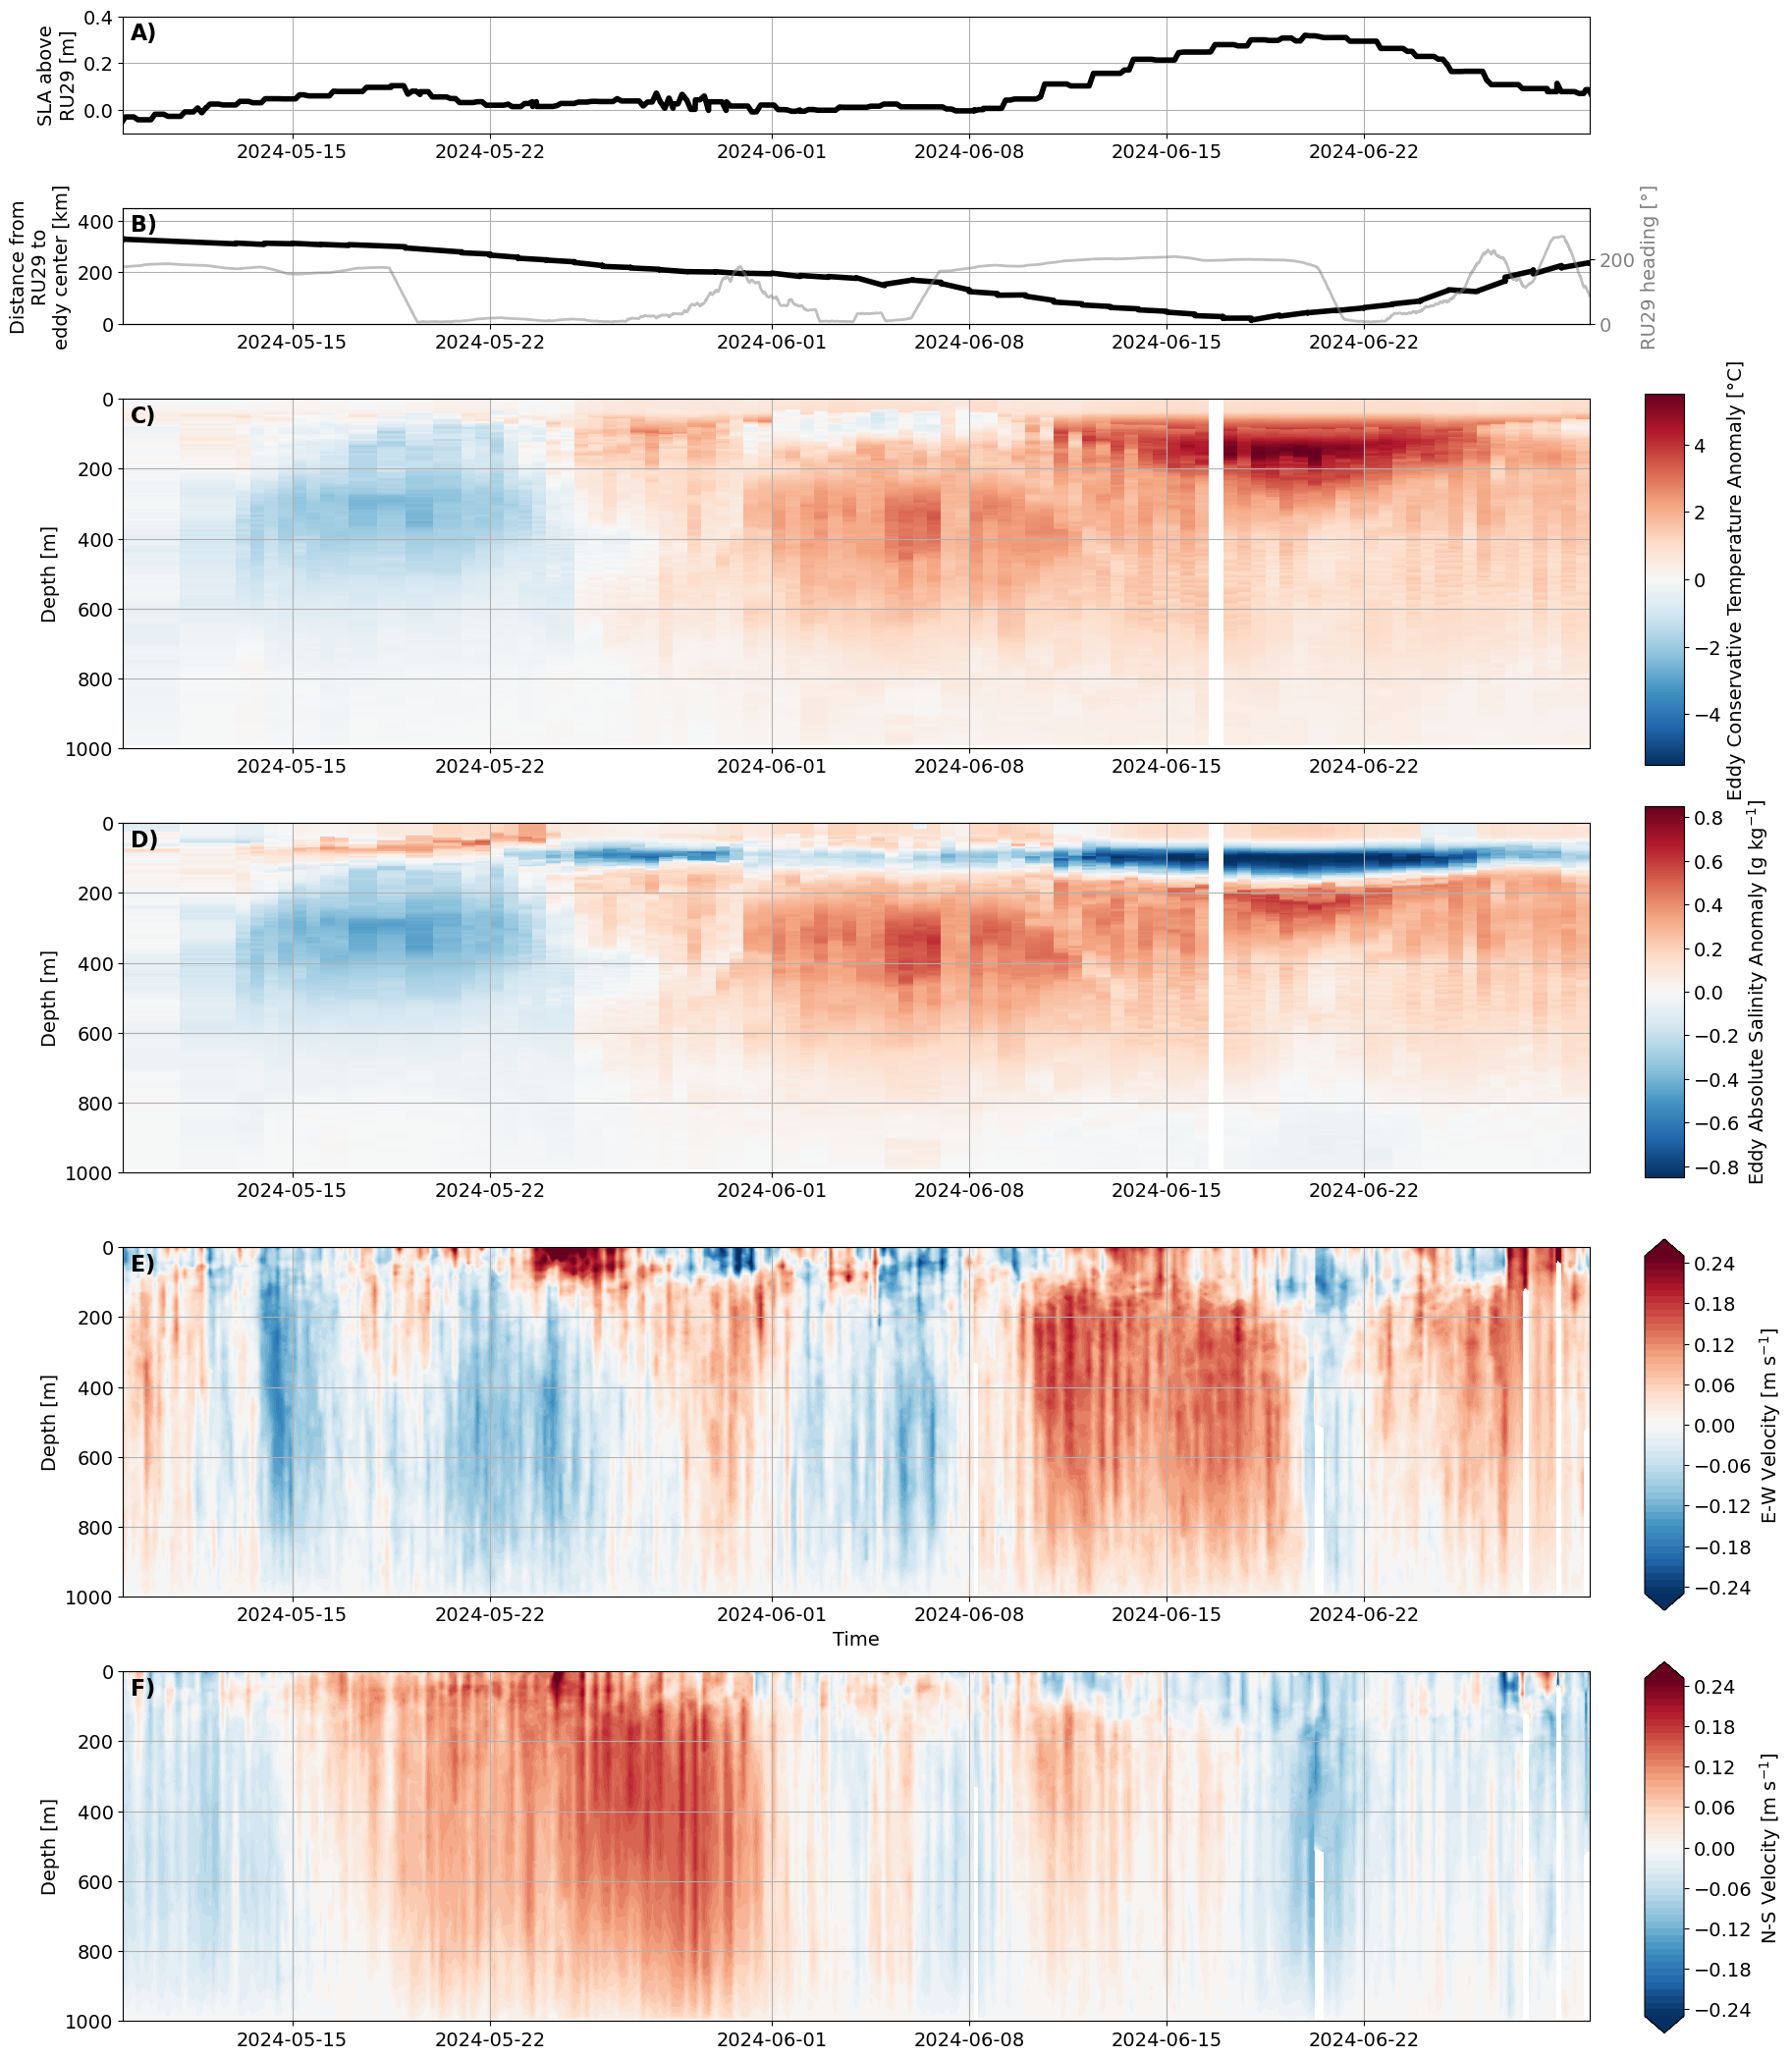

In [36]:
fontsize = 14

# Create figure and gridspec layout (6 rows now)
fig = plt.figure(figsize=(20, 21))
gs = gridspec.GridSpec(6, 2, width_ratios=[1, 0.05], height_ratios=[1, 1, 3, 3, 3, 3])

# --- SLA Panel ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(glider_sla.matched_time, glider_sla.matched_sla, color='black', linewidth=4)
ax1.set_ylabel("SLA above\nRU29 [m]", fontsize=fontsize)
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.set_ylim(-0.1, 0.4)

# --- Distance + Heading Panel ---
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.plot(match_time, match_distance, color='black', linewidth=4)
ax2.set_ylabel("Distance from\nRU29 to\neddy center [km]", fontsize=fontsize)
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.set_ylim(0, 450)

ax22 = ax2.twinx()
ax22.plot(gdf.time, gdf.rolling_mean_heading, zorder=0, alpha=0.5, color='grey', linewidth=2)
ax22.set_ylim(0, 360)
ax22.set_ylabel("RU29 heading [°]", fontsize=fontsize, color='grey')
ax22.tick_params(axis='both', which='major', labelsize=fontsize, labelcolor='grey')

# --- Temperature Anomaly Panel ---
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ca3 = ax3.pcolormesh(match_time, gridded_glider.depth, eddy_conservative_temperature_anomaly,
                     vmin=-5.5, vmax=5.5, cmap='RdBu_r')
ax3.grid(True)
ax3.set_ylabel('Depth [m]', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.set_ylim(1000, 0)

# Temperature colorbar
cbar_ax3 = fig.add_axes([0.84, 0.63, 0.02, 0.18])
cbar3 = fig.colorbar(ca3, cax=cbar_ax3)
cbar3.set_label(label='Eddy Conservative Temperature Anomaly [°C]', size=fontsize)
cbar3.ax.tick_params(labelsize=fontsize)

# --- Salinity Anomaly Panel ---
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
ca4 = ax4.pcolormesh(match_time, gridded_glider.depth, eddy_absolute_salinity_anomaly,
                     vmin=-0.85, vmax=0.85, cmap='RdBu_r')
ax4.grid(True)
ax4.set_ylabel('Depth [m]', fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.set_ylim(1000, 0)

# Salinity colorbar
cbar_ax4 = fig.add_axes([0.84, 0.43, 0.02, 0.18])
cbar4 = fig.colorbar(ca4, cax=cbar_ax4)
cbar4.set_label(label='Eddy Absolute Salinity Anomaly [g kg$^{-1}$]', size=fontsize)
cbar4.ax.tick_params(labelsize=fontsize)

# --- E-W Velocity Panel ---
ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
ca5 = ax5.contourf(adcp_ds.time, adcp_ds.depth, adcp_ds.u_grid,
                   levels=np.arange(-0.25, 0.26, 0.01), cmap='RdBu_r', extend='both')
ax5.grid(True)
ax5.set_ylabel('Depth [m]', fontsize=fontsize)
ax5.set_xlabel('Time', fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.set_ylim(1000, 0)

# E-W Velocity colorbar
cbar_ax5 = fig.add_axes([0.84, 0.22, 0.02, 0.18])
cbar5 = fig.colorbar(ca5, cax=cbar_ax5)
cbar5.set_label(label='E-W Velocity [m s$^{-1}$]', size=fontsize)
cbar5.ax.tick_params(labelsize=fontsize)

# --- N-S Velocity Panel ---
ax6 = fig.add_subplot(gs[5, 0], sharex=ax1)
ca6 = ax6.contourf(adcp_ds.time, adcp_ds.depth, adcp_ds.v_grid,
                   levels=np.arange(-0.25, 0.26, 0.01), cmap='RdBu_r', extend='both')
ax6.grid(True)
ax6.set_ylabel('Depth [m]', fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.set_ylim(1000, 0)

# N-S Velocity colorbar
cbar_ax6 = fig.add_axes([0.84, 0.015, 0.02, 0.18])
cbar6 = fig.colorbar(ca6, cax=cbar_ax6)
cbar6.set_label(label='N-S Velocity [m s$^{-1}$]', size=fontsize)
cbar6.ax.tick_params(labelsize=fontsize)


# --- Final Layout ---
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Set x-limits across all panels
for ax in [ax1, ax2, ax22, ax3, ax4, ax5, ax6]:
    ax.set_xlim(np.min(match_time), pd.to_datetime('2024-06-30'))


ax1.text(0.005,0.8,'A)', transform=ax1.transAxes, size=16, weight='bold')
ax2.text(0.005,0.8,'B)', transform=ax2.transAxes, size=16, weight='bold')
ax3.text(0.005,0.93,'C)', transform=ax3.transAxes, size=16, weight='bold')
ax4.text(0.005,0.93,'D)', transform=ax4.transAxes, size=16, weight='bold')
ax5.text(0.005,0.93,'E)', transform=ax5.transAxes, size=16, weight='bold')
ax6.text(0.005,0.93,'F)', transform=ax6.transAxes, size=16, weight='bold')


# --- Save Figure ---
plt.savefig(
    '../figures/RU29_2024_ABC2DR_AVISO_SLA_Eddy_Distance_Temperature_Salinity_Anomaly_UVVel_VVel.png',
    dpi=300, facecolor='white', bbox_inches='tight'
)


In [195]:
#depth_ind = np.argwhere((gridded_glider.depth.values<250)==True)
depth_ind = np.argwhere(((gridded_glider.depth.values<200)&(gridded_glider.depth.values>0))==True)


In [196]:
center_ind = np.where(match_distance<45)[0]
match_distance[center_ind]


array([39.38195501, 39.36469027, 38.19567046, 38.19474323, 36.98928758,
       36.98875578, 35.81388491, 35.76087557, 34.65747991, 34.60055131,
       33.36074444, 33.32080415, 29.52097829, 29.51774706, 29.53463886,
       28.31054593, 28.32701254, 27.1346013 , 27.18339089, 25.95863253,
       25.99731756, 24.69483129, 24.72069875, 23.43842056, 23.44361844,
       23.52539025, 23.64531621, 22.25582845, 22.31517825, 20.87915577,
       20.92242298, 19.71440689, 19.74966695, 18.59071955, 18.64050593,
       17.13541647, 17.18004497, 15.98685814, 16.02893585, 35.41311356,
       35.4943075 , 34.6376735 , 34.70775609, 33.4939432 , 33.43375514,
       32.87990968, 32.85250615, 32.10531707, 32.10204742, 31.03281678,
       31.01829827, 44.17611462, 44.02076486, 44.38513795, 44.18102717,
       44.47419747, 44.37428514, 44.37258346, 44.37258346])

In [199]:
np.nanmean(eddy_conservative_temperature_anomaly[depth_ind,center_ind])

3.2227927783657426

In [209]:
gridded_glider.depth.values[97]

195.0